In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 10, 3),  # 28x28 output 26x26 RF : 3x3
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout2d(0.05),
           
            nn.Conv2d(10, 10, 3), # 26x26 output 24x24 RF : 5x5
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout2d(0.05),
           
            nn.Conv2d(10, 10, 3), # 24x24 output 22x22 RF : 7x7
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout2d(0.1),
        
        )

        self.trans1 = nn.Sequential(
            
            # nn.Conv2d(24, 12, 1), # 24x24 output 22x22 RF : 7x7
            # nn.ReLU(),
            # nn.BatchNorm2d(12),

            nn.AvgPool2d(2, 2),  # 22x22 output - 11x11 RF 14x14

        )

        self.conv2 =  nn.Sequential(

            nn.Conv2d(10, 10, 3), # 11x11 output - 9x9 RF 16x16
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout2d(0.05),
            
            nn.Conv2d(10, 10, 3),  # 9x9 output - 7x7 RF 18x18
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout2d(0.1),
            
        )

        self.trans2 = nn.Sequential(

            #nn.Conv2d(32, 16, 1), # 9x9 output - 7x7 RF 18x18
            #nn.ReLU(),
            #nn.BatchNorm2d(16),
            nn.AvgPool2d(2, stride=2, padding=0)
        )
        self.fc = nn.Linear(10*3*3,10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.trans2(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return F.log_softmax(x,dim=1)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             910
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
         Dropout2d-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 10, 22, 22]             910
             ReLU-10           [-1, 10, 22, 22]               0
      BatchNorm2d-11           [-1, 10, 22, 22]              20
        Dropout2d-12           [-1, 10, 22, 22]               0
        AvgPool2d-13           [-1, 10, 11, 11]               0
           Conv2d-14             [-1, 1

In [ ]:


torch.manual_seed(1)
batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [ ]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target) 
        train_loss += loss.item()       
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')        
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    return train_loss, 100.*correct/len(train_loader.dataset)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, 100.*correct/len(test_loader.dataset)

In [ ]:
from torch.optim.lr_scheduler import StepLR,OneCycleLR

model = Net().to(device)
lr = 0.1
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss_list = []
test_loss_list = []
train_accuracy_list=[]
test_accuracy_list=[]

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = OneCycleLR(optimizer, max_lr=0.1,epochs=15,steps_per_epoch=len(train_loader))


for epoch in range(0, 15):
    print(f"Epoch {epoch}")
    # if(epoch % 4 == 0):
    #   lr = lr/10
    #   optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    # if(epoch==8):
    #   optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.7)

    #if(epoch==12):
    #  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    train_loss,train_acc = train(model, device, train_loader, optimizer, epoch)
    #scheduler.step()
    test_loss,test_acc = test(model, device, test_loader)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    train_accuracy_list.append(train_acc)
    test_accuracy_list.append(test_acc)



  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 0


loss=0.10974103212356567 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 58.13it/s]


Train set: Average loss: 0.0083, Accuracy: 51492/60000 (85.82%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0986, Accuracy: 9727/10000 (97.27%)

Epoch 1


loss=0.17113398015499115 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 57.27it/s]


Train set: Average loss: 0.0020, Accuracy: 57737/60000 (96.23%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0557, Accuracy: 9822/10000 (98.22%)

Epoch 2


loss=0.08442852646112442 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 56.42it/s]



Train set: Average loss: 0.0014, Accuracy: 58336/60000 (97.23%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Accuracy: 9838/10000 (98.38%)

Epoch 3


loss=0.04011473059654236 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 56.59it/s]


Train set: Average loss: 0.0012, Accuracy: 58516/60000 (97.53%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0375, Accuracy: 9878/10000 (98.78%)

Epoch 4


loss=0.07800965756177902 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 57.16it/s]


Train set: Average loss: 0.0011, Accuracy: 58773/60000 (97.95%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Accuracy: 9893/10000 (98.93%)

Epoch 5


loss=0.11626214534044266 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 56.61it/s]



Train set: Average loss: 0.0009, Accuracy: 58885/60000 (98.14%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9913/10000 (99.13%)

Epoch 6


loss=0.05594412237405777 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 56.59it/s]


Train set: Average loss: 0.0009, Accuracy: 58919/60000 (98.20%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9906/10000 (99.06%)

Epoch 7


loss=0.013014441356062889 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 56.35it/s]


Train set: Average loss: 0.0008, Accuracy: 58995/60000 (98.33%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9918/10000 (99.18%)

Epoch 8


loss=0.001961797708645463 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 57.00it/s]


Train set: Average loss: 0.0008, Accuracy: 59081/60000 (98.47%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9908/10000 (99.08%)

Epoch 9


loss=0.00413103774189949 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 56.25it/s]


Train set: Average loss: 0.0008, Accuracy: 59097/60000 (98.50%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9917/10000 (99.17%)

Epoch 10


loss=0.10633350908756256 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 55.92it/s]


Train set: Average loss: 0.0007, Accuracy: 59143/60000 (98.57%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9929/10000 (99.29%)

Epoch 11


loss=0.0608651228249073 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 56.36it/s]


Train set: Average loss: 0.0007, Accuracy: 59208/60000 (98.68%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9923/10000 (99.23%)

Epoch 12


loss=0.004311195109039545 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 55.29it/s]


Train set: Average loss: 0.0006, Accuracy: 59255/60000 (98.76%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9932/10000 (99.32%)

Epoch 13


loss=0.15016716718673706 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 55.83it/s]


Train set: Average loss: 0.0006, Accuracy: 59280/60000 (98.80%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9931/10000 (99.31%)

Epoch 14


loss=0.05970890074968338 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 56.15it/s]


Train set: Average loss: 0.0006, Accuracy: 59273/60000 (98.79%)




Test set: Average loss: 0.0220, Accuracy: 9930/10000 (99.30%)



Text(0.5, 1.0, 'Loss per epoch')

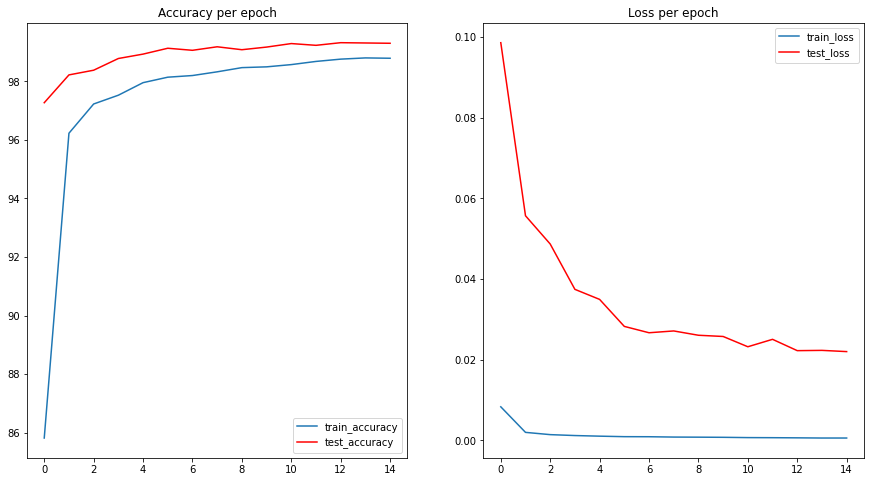

In [ ]:


import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 8]

plt.subplot(1,2, 1)

plt.plot(np.array(train_accuracy_list))
plt.plot(np.array(test_accuracy_list), 'r')
plt.legend(["train_accuracy", "test_accuracy"])
plt.title("Accuracy per epoch")

plt.subplot(1,2,2)
plt.plot(train_loss_list)
plt.plot(test_loss_list, 'r')
plt.legend(["train_loss", "test_loss"])
plt.title("Loss per epoch")

